In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import load_data
import pathlib

# Transfer Learning I: Feature Extraction

In [2]:
dim_old = 28
dim_new = 96
dat_path = pathlib.Path('object_files/').glob('*.npz')
d = {"lollipop":0, "canoe":1, "penguin":2, "eyeglasses":3, "apple":4, "moon":5, "cup":6}
train, train_labels, valid, valid_labels, test, test_labels = load_data.load_for_cnn(dat_path, 
                                                                                     dim_old, d, (0.7, 0.25), 
                                                                                     channel_axes=3, 
                                                                                     dim_new=dim_new)

In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((train, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test, test_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid, valid_labels))

batch_size = 64
train_batches = train_dataset.shuffle(len(train)).batch(batch_size)
validation_batches = valid_dataset.shuffle(len(valid)).batch(batch_size)

In [4]:
img_shape = (96, 96, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

In [5]:
for image_batch, label_batch in train_batches.take(1):
    pass
image_batch.shape

TensorShape([64, 96, 96, 3])

In [6]:
base_model.trainable = False
feature_batch = base_model(image_batch)
print(feature_batch.shape)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(7, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(64, 3, 3, 1280)
(64, 1280)
(64, 7)


In [7]:
initial_epochs = 20
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

20/20 [==============================] - 21s 1s/step - loss: 0.9916 - accuracy: 0.3744


In [8]:
cb = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                          patience=5, min_lr=1e-5, verbose=1)]
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches,
                    callbacks=cb)

Epoch 1/20
766/766 [==============================] - 675s 881ms/step - loss: 0.2048 - accuracy: 0.9221 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
766/766 [==============================] - 647s 844ms/step - loss: 0.0869 - accuracy: 0.9728 - val_loss: 0.2968 - val_accuracy: 0.9018
Epoch 3/20
766/766 [==============================] - 641s 836ms/step - loss: 0.0733 - accuracy: 0.9768 - val_loss: 0.2991 - val_accuracy: 0.9037
Epoch 4/20
766/766 [==============================] - 638s 833ms/step - loss: 0.0679 - accuracy: 0.9784 - val_loss: 0.2970 - val_accuracy: 0.9042
Epoch 5/20
766/766 [==============================] - 625s 816ms/step - loss: 0.0644 - accuracy: 0.9797 - val_loss: 0.3024 - val_accuracy: 0.9041
Epoch 6/20
766/766 [==============================] - 636s 830ms/step - loss: 0.0626 - accuracy: 0.9801 - val_loss: 0.2997 - val_accuracy: 0.9073
Epoch 7/20
765/766 [============================>.] - ETA: 0s - loss: 0.0604 - accuracy: 0.9808
Epoch 00007: ReduceL

# Transfer Learning II: Fine Tuning

In [9]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards (rn, we are fine tuning the top 55 layers)
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  155


In [10]:
len(model.trainable_variables)

58

In [11]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_batches)

Epoch 20/40
766/766 [==============================] - 620s 809ms/step - loss: 0.0571 - accuracy: 0.9818 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 21/40
766/766 [==============================] - 627s 819ms/step - loss: 0.0577 - accuracy: 0.9817 - val_loss: 0.3043 - val_accuracy: 0.9066
Epoch 22/40
766/766 [==============================] - 621s 811ms/step - loss: 0.0574 - accuracy: 0.9817 - val_loss: 0.3076 - val_accuracy: 0.9066
Epoch 23/40
766/766 [==============================] - 624s 815ms/step - loss: 0.0567 - accuracy: 0.9818 - val_loss: 0.3032 - val_accuracy: 0.9067
Epoch 24/40
766/766 [==============================] - 617s 805ms/step - loss: 0.0572 - accuracy: 0.9817 - val_loss: 0.3066 - val_accuracy: 0.9066
Epoch 25/40
766/766 [==============================] - 624s 815ms/step - loss: 0.0573 - accuracy: 0.9818 - val_loss: 0.3052 - val_accuracy: 0.9069
Epoch 26/40
766/766 [==============================] - 616s 804ms/step - loss: 0.0562 - accuracy: 0.9820 - val

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

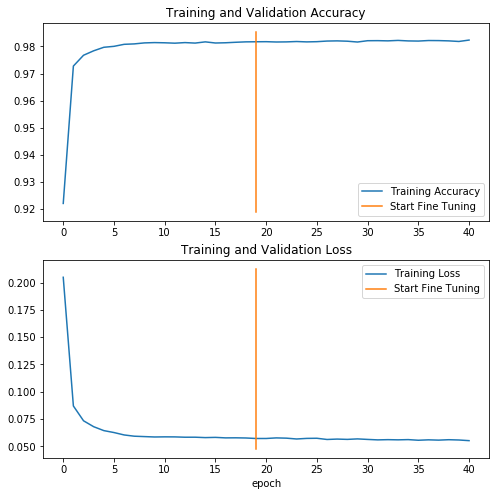

In [13]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

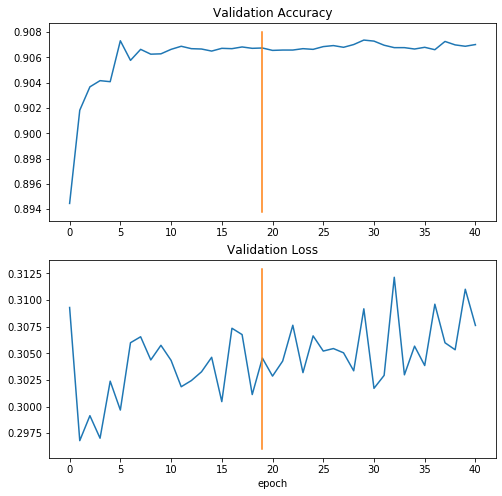

In [14]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.title('Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Validation Loss')
plt.xlabel('epoch')
plt.show()

# Transfer Learning III: Evaluation on the Test Set

In [15]:
test_batches = test_dataset.shuffle(len(test)).batch(batch_size)
loss_test, accuracy_test = model.evaluate(test_batches)

247/247 [==============================] - 159s 644ms/step - loss: 0.3176 - accuracy: 0.9055
